                     y  is_carnival_month  total_holidays
ds                                                       
2014-01-01 3602793.670              0.000           1.000
2014-02-01 6142804.610              0.000           0.000
2014-03-01 5308194.650              1.000           2.000
2014-04-01 6824498.880              0.000           2.000
2014-05-01 6168703.880              0.000           1.000


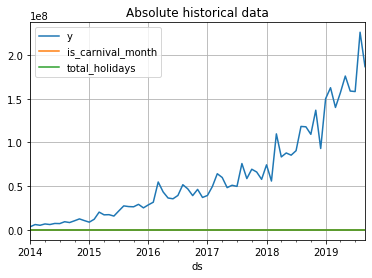

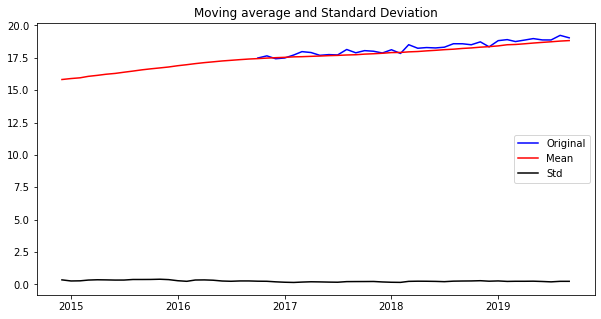

Best ADF Test Results
Statistical Test         -9.295
p-value                   0.000
#Lags used                1.000
Number of observations   54.000
Critical value 1%        -3.558
Critical value 5%        -2.917
Critical value 10%       -2.596
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   69
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  35.174
Date:                            Wed, 06 Nov 2019   AIC                            -60.347
Time:                                    02:25:49   BIC                            -50.221
Sample:                                01-01-2014   HQIC                           -56.421
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_carnival_month    -0.3670      0.155     -2.362      0.018      -0.671      -0.063
total_holidays

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

invalid value encountered in log



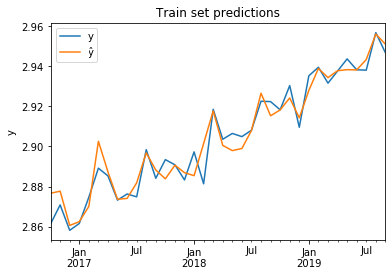

      DATASET METRICS
RMSE            0.007
AIC           -60.347
BIC           -50.221
HQIC          -56.421
MAPE            0.170
MAE             0.000


ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import statsmodels.api as sm

from math import sqrt
from plotly.offline import iplot, init_notebook_mode
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Granting that pandas will not use scientific notation for floating fields
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

# Using Matplotlib figures inline
%matplotlib inline

# Setting Plot.ly to work on notebooks
init_notebook_mode(connected=True)

# Defining some functions
def mean_abs_pct_error(actual_values, forecast_values):
    '''
    MAPE function to understand the average error percentage of the model

    Args.:
        actual_values (Numpy 1D Array, List or Iterable): True values of the set
        forecast_values (Numpy 1D Array, List or Iterable): Values predicted by the model
    Return:
        MAPE value (float)
    '''
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i]) / actual_values.values[i]
    return err * 100/len(forecast_values)

def decompose_series(ts):
    '''
    This function applies a seasonal decomposition to a time series. It will generate a season plot, a trending plot, and, finally, a resid plot

    Args.
        ts (Pandas Series): a time series to be decomposed
    '''
    fig = plt.Figure(figsize=(12,7))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    decomposition = seasonal_decompose(ts)

    decomposition.seasonal.plot(ax=ax1, title='Sazonality')
    plt.legend('')

    decomposition.trend.plot(ax=ax2, title='Trending')
    plt.legend('')

    decomposition.resid.plot(ax=ax3, title='Resid')
    plt.legend('')

    plt.subplots_adjust(hspace=1)
    plt.show()

def find_acf_pacf(timeseries, seasonality):
    '''
    Function to find the amount of terms for p and q
    Args.
        timeseries (Pandas Series): a time series to estimate the p and q terms
        seasonality (int): the seasonality is used to estimate the amount of lags to consider. By default, this function will use seasonality * 2 lags
            to compute ACF and PACF
    '''

    fig = plt.Figure(figsize=(12,7))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    # Ploting the ACF function
    sm.graphics.tsa.plot_acf(timeseries.dropna(), lags = seasonality * 2, ax=ax1)

    # Ploting the PACF function
    sm.graphics.tsa.plot_pacf(timeseries.dropna(), lags = seasonality * 2, ax=ax2)

    plt.subplots_adjust(hspace=.4)
    plt.show()

def predict_set(timeseries, y, seasonality, transformation_function, model, forecast=False):
    '''
    Predicts the in-sample train observations

    Args.
        timeseries (Pandas Series): a time series that was used to fit a model
        y (str): the target column
        seasonality (int): the seasonality frequency
        transformation_function (func): a function used to transform the target values
        model (Statsmodel object): a fitted model
        forecast (bool): wether or not forecast the test set
    '''
    timeseries = timeseries.to_frame()
    timeseries[y] = transformation_function(timeseries[y])

    if forecast:
        timeseries['ŷ'] = transformation_function(model.forecast(len(timeseries)))
    else:
        timeseries['ŷ'] = transformation_function(model.predict())

    timeseries[[y, 'ŷ']].iloc[-(seasonality*3):].plot()

    plt.ylabel(y)
    plt.xlabel('')
    plt.title('Train set predictions')
    plt.show()

    rmse = sqrt(mean_squared_error(timeseries[y].iloc[-(seasonality*3):], 
                                   timeseries['ŷ'].iloc[-(seasonality*3):]))
    aic = model.aic
    bic = model.bic
    hqic = model.hqic
    mape = np.round(mean_abs_pct_error(timeseries[y].iloc[-(seasonality*3):], 
                    timeseries['ŷ'].iloc[-(seasonality*3):]), 2)
    mae = np.round(mean_absolute_error(timeseries[y].iloc[-(seasonality*3):], 
                   timeseries['ŷ'].iloc[-(seasonality*3):]), 2)

    metrics_df = pd.DataFrame(data=[rmse, aic, bic, hqic, mape, mae], 
                              columns = ['DATASET METRICS'], 
                              index = ['RMSE', 'AIC', 'BIC', 'HQIC', 'MAPE', 'MAE'])
    print(metrics_df)

def grid_search(train_data, exog,  p_range, q_range, P_range, Q_range, d=1, D=1, s=12):
    '''
    Grid search for SARIMAX models. This is a time consuming function that will iterate
    over different terms for AR and MA.

    Args:
        train_data (Pandas Series, Numpy Array, iterable): the training data containing endog variables
        exog (Pandas Series, Numpy Array, iterable): exogenous variables
        p_range (iterable): range of terms for p
        d_range (int): differencing terms
        q_range (iterable): range of terms for q
        P_range (iterable): range of terms for Q
        D_range (int): seasonal differencing terms
        Q_range (iterable): range of terms for Q
        s (int): seasonal frequency
    Return:
        current_best_model (Statsmodels SARIMAX results): a model with the best parameters, 
            based on AIC, BIC, and HQIC metrics
        models (list): all past models metrics for each iteractions
    '''
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0, 0, 0)
    models = []

    for p_ in p_range:
        for q_ in q_range:
            for P_ in P_range:
                for Q_ in Q_range:
                    try:
                        no_of_lower_metrics = 0
                        model = sm.tsa.statespace.SARIMAX(endog = train_data,
                                                        order = (p_, d, q_),
                                                        exog = exog,
                                                        seasonal_order = (P_, D, Q_, s),
                                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics += 1
                        if model.bic <= best_model_bic: no_of_lower_metrics += 1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics += 1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" + str(best_model_order) + 
                                "AIC: {} BIC: {} HQIC: {}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                "Resid: {}".format(np.round(np.exp(current_best_model.resid).mean(), 3)))
                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models

def plot_forecasts(forecasts, confidence_interval, periods):
    '''
    Generate a plot with the forecasted observations

    Args.
        forecasts (Pandas Series): out-of-sample observations
        confidence_interval (Pandas DataFrame): DataFrame containing a column for the lower boundary and another for the upper boundary 
        periods (int): how much periods to forecast?
    '''
    lower_ci = dict(x = confidence_interval.index, 
                    y = confidence_interval['ci_lower'], 
                    line = dict(
                            color = '#1EBC61', 
                            shape = 'linear',
                            width = 0.1
                                ), 
                    mode = 'lines',
                    name = 'Lower 95% CI', 
                    showlegend = False, 
                    type = "scatter", 
                    xaxis = 'x', 
                    yaxis = 'y')
    upper_ci = dict(x = confidence_interval.index, 
                    y = confidence_interval['ci_upper'], 
                    fill = 'tonexty', 
                    line = dict(
                            color = '#1EBC61', 
                            shape = 'linear',
                            width = 0.1
                                ), 
                    mode = 'lines', 
                    name = 'Upper 95% CI', 
                    type = 'scatter', 
                    xaxis = 'x', 
                    yaxis = 'y')
    forecasting =  dict(x = forecasts.index, 
                        y = forecasts.values,
                        line = dict(
                                color = '#005C01', 
                                shape = 'linear',
                                width = 3
                                ), 
                    mode = 'lines', 
                    name = 'Forecasting', 
                    type = 'scatter', 
                    xaxis = 'x', 
                    yaxis = 'y')

    plot_data = ([lower_ci, upper_ci, forecasting])
    layout = go.Layout(title = str(periods) + ' Forecasts')
    fig = go.Figure(data = plot_data, layout=layout)
    iplot(fig)

# Reading dataset
df = pd.read_csv('../datasets/hotmart_gmv.csv')

# Reading dataset
df.set_index('ds', inplace = True)
df.index = df.index.astype('datetime64[ns]')
print(df.head())

# Plotting your historical data
df.plot(grid=True)
plt.title('Absolute historical data')
plt.show()

# Creating exogenous variables
exogenous_variables = df[['is_carnival_month', 'total_holidays']]

# Transforming data to a series
df = df['y']            

# Applying Augmented Dickey-Fuller test
df = np.log(df)
dftest = adfuller(df.diff().diff(12).dropna(), autolag='AIC')

# Checking rolling statistics
mean = df.rolling(window=12).mean()
std = df.rolling(window=12).std()

# Plotting rolling statistics
fig = plt.figure(figsize=(10, 5))
orig = plt.plot(df.iloc[-36:], color='blue', label='Original')
mean = plt.plot(mean, color='red', label='Mean')
std = plt.plot(std, color='black', label='Std')

plt.legend(loc='best')
plt.title(f'Moving average and Standard Deviation')
plt.show()

# Performing Dickey-Fuller test
print('Best ADF Test Results')
critical_value_1_perc = dftest[4]['1%']

dfoutput = pd.Series(dftest[0:4], index=['Statistical Test', 'p-value', '#Lags used', 'Number of observations'])
for key, value in dftest[4].items():
    dfoutput['Critical value ' + key] = value
print(dfoutput)

train_transformation_func = np.log
train_set = train_transformation_func(df.iloc[:-12])
test_set = train_transformation_func(df.iloc[-12:])

# Training model
mod = sm.tsa.statespace.SARIMAX(df,
                                order = (1, 1, 0),
                                exog = exogenous_variables,
                                seasonal_order = (1, 1, 0, 12),
                                enforce_invertibility=False)
# Fitting model
mod = mod.fit()
print(mod.summary())

## Uncomment this part to use Grid Search (computational expensive)
#grid_search(df, exogenous_variables, range(4), 1, range(3), range(4), 1, range(3), 12)

predict_set(df, 'y', 12, np.log, mod)

# Forecasting out-of-sample periods
forecasts = np.exp(mod.forecast(6))
confidence_interval = np.exp(mod.get_forecast(6).conf_int())

# Generating confidence interval and plotting forecasting
confidence_interval.columns = ['ci_lower', 'ci_upper']
plot_forecasts(forecasts, confidence_interval, 'Monthly')